In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import h5py
import multiprocessing
from math import pi

from analysis.config import birds, h5_path_dict, pickle_dir
from analysis.ExpData import ExpData
from analysis.utils import popln_overlap, get_fr
import analysis.shuffle as shuffle

In [12]:
with open(pickle_dir / 'population_patterns.p', 'rb') as f: 
    population_patterns = pickle.load(f)

In [3]:
def get_site_distance(a, b):
    dist = min(
        abs(a - b), 16 - abs(a-b)
        ) % 16
    return dist

# Switching Dynamics: Is the place mode co-active with episode mode?

### Method 1: Plot mean place activity around time of cache/retrieval reactivation

#### i. Load hop-centered visits

In [22]:
all_reactiv_times = {} # Contains (c, r) pairs of frametimes
all_reactiv_sites = {}
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_visits = population_patterns[fil_string]['c_visits']
    r_visits = population_patterns[fil_string]['r_visits']
    noncr_visits = population_patterns[fil_string]['noncr_visits']
    visit_patterns = population_patterns[fil_string]['visit_patterns']
    visit_times = population_patterns[fil_string]['visit_times']
    all_reactiv_times[fil_string] = []
    all_reactiv_sites[fil_string] = []

    for i, c_visit in enumerate(c_visits):
        c_site = exp_data.event_sites[exp_data.cache_event][i]
        cache_pattern_mat = visit_patterns[c_visit]
        for j, r_visit in enumerate(r_visits):
            if r_visit <= c_visit: continue
            r_site = exp_data.event_sites[exp_data.retriev_event][j]
            if r_site != c_site: continue
            retriev_pattern_mat = visit_patterns[r_visit]
            overlaps = []
#             for retriev_pattern in retriev_pattern_mat.T:
#                 cache_retriev_overlap = popln_overlap(
#                     cache_pattern_mat, retriev_pattern
#                     )
#                 overlaps.append(np.nanmax(cache_retriev_overlap))
#             if len(overlaps) > 0:
#                 #all_overlaps.append(np.nanmax(overlaps))
#                 all_reactiv_times[fil_string].append([
                    
#                     ])
#                 all_reactiv_sites[fil_string].append(c_site)
            
            reactiv_times = []
            for k, retriev_pattern in enumerate(retriev_pattern_mat.T):
                event_overlap = popln_overlap(
                    cache_pattern_mat, retriev_pattern
                    )
#                 if np.sum(np.isnan(event_overlap)) == event_overlap.size:
#                     continue
                overlaps.append(np.nanmax(event_overlap))
                reactiv_times.append([
                    visit_times[c_visit][np.nanargmax(event_overlap)],
                    visit_times[r_visit][k]
                    ])
            if len(overlaps) > 0:
                all_reactiv_times[fil_string].append(
                    reactiv_times[np.nanargmax(overlaps)]
                    )
                all_reactiv_sites[fil_string].append(c_site)
                #all_overlaps.append(np.nanmax(overlaps))
            break        

/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: All-NaN slice encountered


ValueError: All-NaN slice encountered

#### ii. Test to make sure indices are correctly found

In [ ]:
tests = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    fr = population_patterns[fil_string]['fr']
    times = all_reactiv_times[fil_string]
    for time in times:
        c = fr[:, time[0]]
        r = fr[:, time[1]]
        ov = popln_overlap(c[:,None], r)
        tests.append(ov.item())

In [ ]:
plt.figure()
plt.hist(tests, bins=20, alpha=0.4, weights=np.ones(len(tests)) / len(tests))
plt.show()

In [ ]:
len(tests)

#### iii. Plot place activity around time of reactivation

In [ ]:
with open(pickle_dir / 'place_cells_1d.p', 'rb') as f: 
    all_place_cells = pickle.load(f)

In [ ]:
with open(pickle_dir / 'episode_cells_overlap.p', 'rb') as f: 
    all_ep_cells = pickle.load(f)

In [ ]:
window = 5*20
c_activity = [[] for _ in range(window*2 + 1)]
r_activity = [[] for _ in range(window*2 + 1)]
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    fr = population_patterns[fil_string]['fr']
    pl_sig = all_place_cells[fil_string]['significance']
    pl_info = all_place_cells[fil_string]['spatial_info']
    ep_sig = all_ep_cells[fil_string]['significance']
    sig = np.logical_and(pl_sig, np.logical_not(ep_sig))
    reactiv_times = all_reactiv_times[fil_string]
    reactiv_sites = all_reactiv_sites[fil_string]
    for (c_time, r_time) in reactiv_times:
        c_range = np.arange(c_time-window, c_time+window+1)
        r_range = np.arange(r_time-window, r_time+window+1)
        for i, frame in enumerate(c_range):
            popln_activ = fr[sig, frame]
            val = np.nanmean(popln_activ)
            c_activity[i].append(val)
        for i, frame in enumerate(r_range):
            activ = np.nanmean(fr[sig, frame])
            r_activity[i].append(activ)

In [ ]:
# Plot figures
x = np.array(c_activity)
mean = np.nanmean(x, axis=1)
std = np.nanstd(x, axis=1)
xticks = (np.arange(mean.size) - mean.size//2)/20
plt.plot(xticks, mean, label="Mean")
plt.plot(xticks, np.nanmedian(x, axis=1), color="red", label="Median")
plt.fill_between(
    xticks, mean+std, mean-std,
    color="gray", alpha=0.3)
plt.title("Place-Only activity around Cache Memory")
plt.xlabel("Time to Reactivation (s)")
plt.legend()
plt.show()

x = np.array(r_activity)
mean = np.nanmean(x, axis=1)
std = np.nanstd(x, axis=1)
xticks = (np.arange(mean.size) - mean.size//2)/20
plt.plot(xticks, mean, label="Mean")
plt.plot(xticks, np.nanmedian(x, axis=1), color="red", label="Median")
plt.fill_between(
    xticks, mean+std, mean-std,
    color="gray", alpha=0.3)
plt.title("Place-Only activity around Retrieval Memory")
plt.xlabel("Time to Reactivation (s)")
plt.legend()
plt.show()

#### iv. Plot place-tuned activity around time of reactivation

In [46]:
with open(pickle_dir / 'place_cells_1d.p', 'rb') as f: 
    all_place_cells = pickle.load(f)

In [10]:
with open(pickle_dir / 'episode_cells_overlap.p', 'rb') as f: 
    all_ep_cells = pickle.load(f)

In [99]:
window = 5*20
c_activity = [[] for _ in range(window*2 + 1)]
r_activity = [[] for _ in range(window*2 + 1)]
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    fr = population_patterns[fil_string]['fr']
    pl_sig = all_place_cells[fil_string]['significance']
    pl_info = all_place_cells[fil_string]['spatial_info']
    pl_tuning = all_place_cells[fil_string]['tuning']
    ep_sig = all_ep_cells[fil_string]['significance']
    sig = pl_sig #np.logical_and(pl_sig, np.logical_not(ep_sig))
    reactiv_times = all_reactiv_times[fil_string]
    reactiv_sites = all_reactiv_sites[fil_string]
    for (c_time, r_time), site in zip(reactiv_times, reactiv_sites):
        c_range = np.arange(c_time-window, c_time+window+1)
        r_range = np.arange(r_time-window, r_time+window+1)
        site_relev = np.logical_and(
            sig, pl_tuning[:, site - 1]
            )
        if np.sum(site_relev) == 0: continue
        for i, frame in enumerate(c_range):
            popln_activ = fr[site_relev, frame]
            val = np.nanmean(popln_activ)
            c_activity[i].append(val)
        for i, frame in enumerate(r_range):
            activ = np.nanmean(fr[site_relev, frame])
            r_activity[i].append(activ)

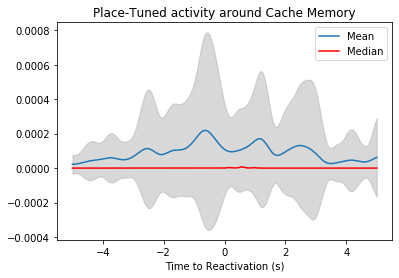

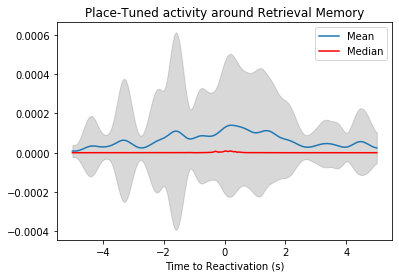

In [101]:
# Plot figures
x = np.array(c_activity)
mean = np.nanmean(x, axis=1)
std = np.nanstd(x, axis=1)
xticks = (np.arange(mean.size) - mean.size//2)/20
plt.plot(xticks, mean, label="Mean")
plt.plot(xticks, np.nanmedian(x, axis=1), color="red", label="Median")
plt.fill_between(
    xticks, mean+std, mean-std,
    color="gray", alpha=0.3)
plt.title("Place-Tuned activity around Cache Memory")
plt.xlabel("Time to Reactivation (s)")
plt.legend()
plt.show()

x = np.array(r_activity)
mean = np.nanmean(x, axis=1)
std = np.nanstd(x, axis=1)
xticks = (np.arange(mean.size) - mean.size//2)/20
plt.plot(xticks, mean, label="Mean")
plt.plot(xticks, np.nanmedian(x, axis=1), color="red", label="Median")
plt.fill_between(
    xticks, mean+std, mean-std,
    color="gray", alpha=0.3)
plt.title("Place-Tuned activity around Retrieval Memory")
plt.xlabel("Time to Reactivation (s)")
plt.legend()
plt.show()

#### v. Do some shuffles

In [50]:
window = 5*20
c_activity = [[] for _ in range(window*2 + 1)]
r_activity = [[] for _ in range(window*2 + 1)]
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    fr = population_patterns[fil_string]['fr']
    pl_sig = all_place_cells[fil_string]['significance']
    pl_info = all_place_cells[fil_string]['spatial_info']
    pl_tuning = all_place_cells[fil_string]['tuning']
    ep_sig = all_ep_cells[fil_string]['significance']
    sig = np.logical_and(pl_sig, np.logical_not(ep_sig))
    reactiv_times = all_reactiv_times[fil_string]
    reactiv_sites = all_reactiv_sites[fil_string]
    for (c_time, r_time), site in zip(reactiv_times, reactiv_sites):
        c_range = np.arange(c_time-window, c_time+window+1)
        r_range = np.arange(r_time-window, r_time+window+1)
        site_relev = np.logical_and(
            sig, pl_tuning[:, site - 1]
            )
        if np.sum(site_relev) == 0: continue
        for i, frame in enumerate(c_range):
            popln_activ = fr[site_relev, frame]
            val = np.nanmean(popln_activ)
            c_activity[i].append(val)
        for i, frame in enumerate(r_range):
            activ = np.nanmean(fr[site_relev, frame])
            r_activity[i].append(activ)

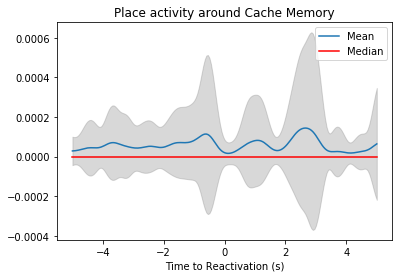

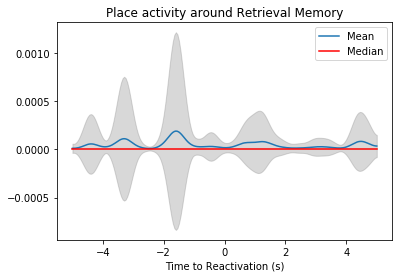

In [51]:
# Plot figures
x = np.array(c_activity)
mean = np.nanmean(x, axis=1)
std = np.nanstd(x, axis=1)
xticks = (np.arange(mean.size) - mean.size//2)/20
plt.plot(xticks, mean, label="Mean")
plt.plot(xticks, np.nanmedian(x, axis=1), color="red", label="Median")
plt.fill_between(
    xticks, mean+std, mean-std,
    color="gray", alpha=0.3)
plt.title("Place activity around Cache Memory")
plt.xlabel("Time to Reactivation (s)")
plt.legend()
plt.show()

x = np.array(r_activity)
mean = np.nanmean(x, axis=1)
std = np.nanstd(x, axis=1)
xticks = (np.arange(mean.size) - mean.size//2)/20
plt.plot(xticks, mean, label="Mean")
plt.plot(xticks, np.nanmedian(x, axis=1), color="red", label="Median")
plt.fill_between(
    xticks, mean+std, mean-std,
    color="gray", alpha=0.3)
plt.title("Place activity around Retrieval Memory")
plt.xlabel("Time to Reactivation (s)")
plt.legend()
plt.show()

### Method 2: Look at correlations between episode-only cells and place-only cells

In [23]:
corrs = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    fr = population_patterns[fil_string]['fr']
    pl_sig = all_place_cells[fil_string]['significance']
    pl_info = all_place_cells[fil_string]['spatial_info']
    ep_sig = all_ep_cells[fil_string]['significance']
    cache_idx_mat = all_ep_cells[fil_string]['cr_idx_mat']
    pl_sig = np.logical_and(pl_sig, np.logical_not(ep_sig))
    ep_sig = np.logical_and(ep_sig, np.logical_not(pl_sig))
    
    c_visits = population_patterns[fil_string]['c_visits']
    r_visits = population_patterns[fil_string]['r_visits']

    for i, c_visit in enumerate(c_visits):
        c_site = exp_data.event_sites[exp_data.cache_event][i]
        for j, r_visit in enumerate(r_visits):
            if r_visit <= c_visit: continue
            r_site = exp_data.event_sites[exp_data.retriev_event][j]
            if r_site != c_site: continue
            start_frame = int(exp_data.visit_exits[c_visit])
            end_frame = int(exp_data.visit_enters[r_visit])
            ep_tuned = np.logical_and(ep_sig, cache_idx_mat[i,:] > 0)
#             for pl in np.argwhere(pl_sig):
#                 for ep in np.argwhere(ep_sig):
#                     c = np.corrcoef(
#                         fr[pl,start_frame:end_frame],
#                         fr[ep,start_frame:end_frame]
#                         )[0,1]
#                     corrs.append(c)
            c = np.corrcoef(
                np.nanmean(fr[pl_sig, start_frame:end_frame], axis=0),
                np.nanmean(fr[ep_tuned, start_frame:end_frame], axis=0)
                )[0,1]
            corrs.append(c)
            break

/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


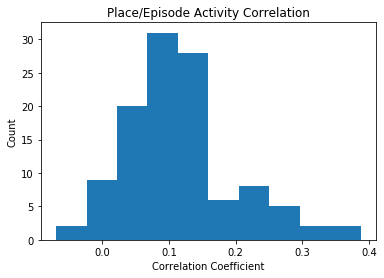

In [24]:
plt.figure()
plt.hist(corrs)
plt.title("Place/Episode Activity Correlation")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Count")
plt.show()

In [25]:
shuff_corrs = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    fr = population_patterns[fil_string]['fr']
    pl_sig = all_place_cells[fil_string]['significance']
    pl_info = all_place_cells[fil_string]['spatial_info']
    ep_sig = all_ep_cells[fil_string]['significance']
    cache_idx_mat = all_ep_cells[fil_string]['cr_idx_mat']
    pl_sig = np.logical_and(pl_sig, np.logical_not(ep_sig))
    ep_sig = np.logical_and(ep_sig, np.logical_not(pl_sig))
    
    c_visits = population_patterns[fil_string]['c_visits']
    r_visits = population_patterns[fil_string]['r_visits']

    for i, c_visit in enumerate(c_visits):
        c_site = exp_data.event_sites[exp_data.cache_event][i]
        for j, r_visit in enumerate(r_visits):
            if r_visit <= c_visit: continue
            r_site = exp_data.event_sites[exp_data.retriev_event][j]
            if r_site != c_site: continue
#             c_visit = np.random.choice(np.arange(exp_data.visit_enters.size))
#             r_visit = np.random.choice(np.arange(exp_data.visit_enters.size))
#             shuff_fr = get_fr(shuffle.circular(exp_data.spikes), int(20*0.25))
#             scaling = np.square(np.linalg.norm(shuff_fr, axis=1))
#             shuff_fr /= scaling[:, None]
            start_frame = int(exp_data.visit_exits[c_visit])
            end_frame = int(exp_data.visit_enters[r_visit])
            ep_tuned = np.logical_and(ep_sig, cache_idx_mat[i,:] > 0)
            
            shuff_pl_sig = np.zeros(pl_sig.size).astype(bool)
            shuff_pl_sig[np.random.choice(pl_sig.size, np.sum(pl_sig), replace=False)] = True
            possib = [num for num in np.arange(pl_sig.size) if not pl_sig[num]]
            shuff_ep_tuned = np.zeros(ep_tuned.size).astype(bool)
            shuff_ep_tuned[np.random.choice(possib, np.sum(ep_tuned), replace=False)] = True
            
            c = np.corrcoef(
                np.nanmean(fr[shuff_pl_sig, start_frame:end_frame], axis=0),
                np.nanmean(fr[shuff_ep_tuned, start_frame:end_frame], axis=0)
                )[0,1]
            shuff_corrs.append(c)
            break

/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater
/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


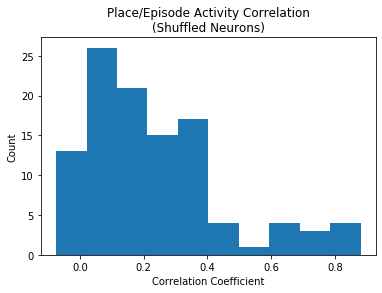

In [26]:
plt.figure()
plt.hist(shuff_corrs)
plt.title("Place/Episode Activity Correlation\n(Shuffled Neurons)")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Count")
plt.show()